# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

from sklearn.dummy import DummyRegressor

import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
print('-Типы данных-')
data.info()

-Типы данных-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int

In [4]:
print('-Первые 10 строк-')
data.head(10)

-Первые 10 строк-


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
print('-Статистическая сводка-')
display(data.describe())

-Статистическая сводка-


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
print('-Статистическая сводка категориальных признаков-')
data.describe(include=['object', 'bool'])

-Статистическая сводка категориальных признаков-


,DateCrawled,VehicleType,Gearbox,Model,FuelType,Brand,Repaired,DateCreated,LastSeen
count,354369,316879,334536,334664,321474,354369,283215,354369,354369
unique,271174,8,2,250,7,40,2,109,179150
top,2016-03-24 14:49:47,sedan,manual,golf,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:45:54
freq,7,91457,268251,29232,216352,77013,247161,13719,17


In [7]:
print('-Пропуски-')
count = 0
for element in data.columns:
    if data[element].isna().sum() > 0: 
        print(element, ' - ', data[element].isna().sum(), 'пропусков') 
        count = +1
    if count == 0:
        print('Пропусков не обнаружено')

-Пропуски-
Пропусков не обнаружено
Пропусков не обнаружено
VehicleType  -  37490 пропусков
Gearbox  -  19833 пропусков
Model  -  19705 пропусков
FuelType  -  32895 пропусков
Repaired  -  71154 пропусков


In [8]:
print('-Процент пропусков от всего датасета-')
display(data.isna().mean().sort_values(ascending=False)*100)

-Процент пропусков от всего датасета-


Repaired             20.079070
VehicleType          10.579368
FuelType              9.282697
Gearbox               5.596709
Model                 5.560588
DateCrawled           0.000000
Price                 0.000000
RegistrationYear      0.000000
Power                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
Brand                 0.000000
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [9]:
print('-Дубликаты-\n')
if data.duplicated().sum() > 0:
    print('Дубликатов: ', data.duplicated().sum())
else:
    print('Дубликатов не обнаружено')

-Дубликаты-

Дубликатов:  4


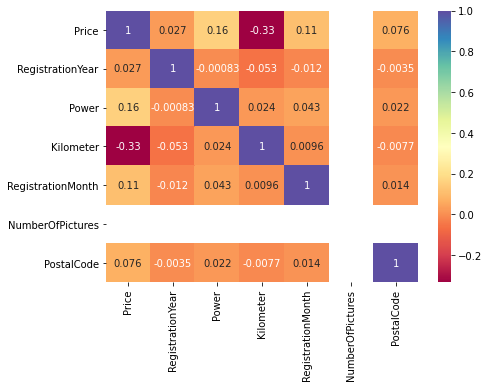

In [10]:
plt.figure(figsize = (7,5))
df_plot = sns.heatmap(data.corr(), cmap="Spectral", annot=True)       
plt.show()

In [11]:
print('-Значимые признаки-')
data1 = data[['VehicleType',
              'Repaired',               
              'FuelType',
              'RegistrationYear', 
              'Gearbox', 
              'Model',
              'Power',
              'Kilometer',            
              'Brand',
              'Price']]
data1.info()

-Значимые признаки-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       316879 non-null  object
 1   Repaired          283215 non-null  object
 2   FuelType          321474 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           334536 non-null  object
 5   Model             334664 non-null  object
 6   Power             354369 non-null  int64 
 7   Kilometer         354369 non-null  int64 
 8   Brand             354369 non-null  object
 9   Price             354369 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


In [12]:
print('-Исследуем целевой признак-')
data1['Price'].value_counts()

-Исследуем целевой признак-


0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: Price, Length: 3731, dtype: int64

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Price</b>    
</p>
</div>

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

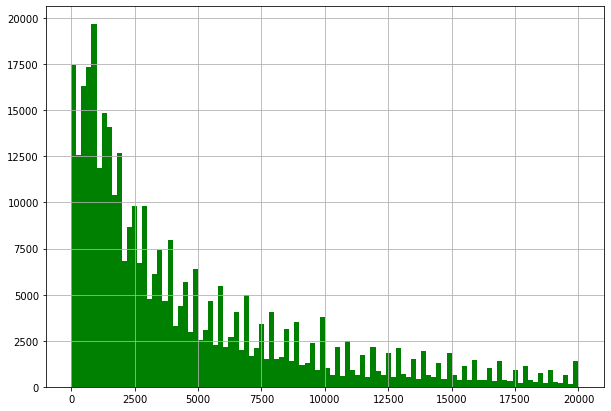

In [13]:
data1['Price'].hist(bins=100, color='green', figsize=(10,7))
data1['Price'].describe()

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Удалим все строки, содержащие 0 и построим гистограмму.   
</p>
</div>

count    343597.000000
mean       4555.121974
std        4515.058553
min           1.000000
25%        1200.000000
50%        2890.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

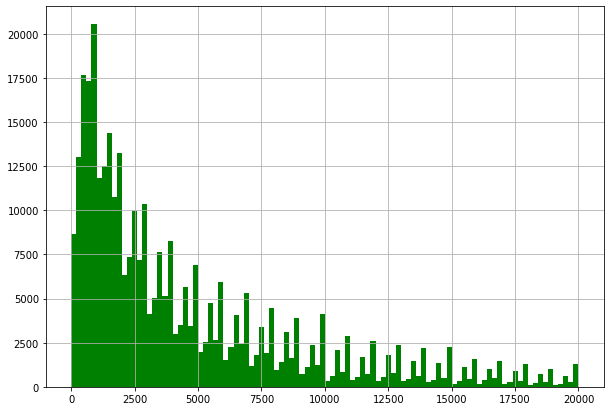

In [14]:
data1 = data1.query('Price > 0')
data1['Price'].hist(bins=100, color='green', figsize=(10,7))
data1['Price'].describe()

In [15]:
data1['Price'].quantile([0.1, 0.9])

0.1      590.0
0.9    11500.0
Name: Price, dtype: float64

In [16]:
data1 = data1.query('590 <= Price <= 11500')
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275222 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       250663 non-null  object
 1   Repaired          225684 non-null  object
 2   FuelType          254219 non-null  object
 3   RegistrationYear  275222 non-null  int64 
 4   Gearbox           263098 non-null  object
 5   Model             262333 non-null  object
 6   Power             275222 non-null  int64 
 7   Kilometer         275222 non-null  int64 
 8   Brand             275222 non-null  object
 9   Price             275222 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 23.1+ MB


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>RegistrationYear</b>    
</p>
</div>

count    275222.000000
mean       2003.686838
std          63.744556
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

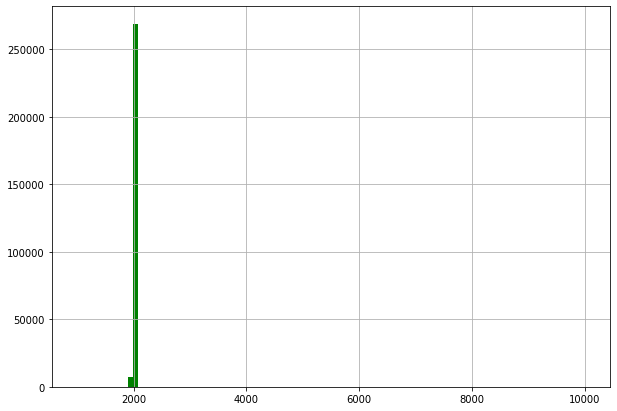

In [17]:
data1['RegistrationYear'].hist(bins=100, color='green', figsize=(10,7))
data1['RegistrationYear'].describe()

In [18]:
date_min = pd.to_datetime(data['RegistrationYear'])
date_min.min()

Timestamp('1970-01-01 00:00:00.000001')

In [19]:
date_max = pd.to_datetime(data['DateCrawled'])
date_max.max()

Timestamp('2016-04-07 14:36:58')

count    256164.000000
mean       2002.196460
std           5.581097
min        1971.000000
25%        1999.000000
50%        2003.000000
75%        2006.000000
max        2015.000000
Name: RegistrationYear, dtype: float64

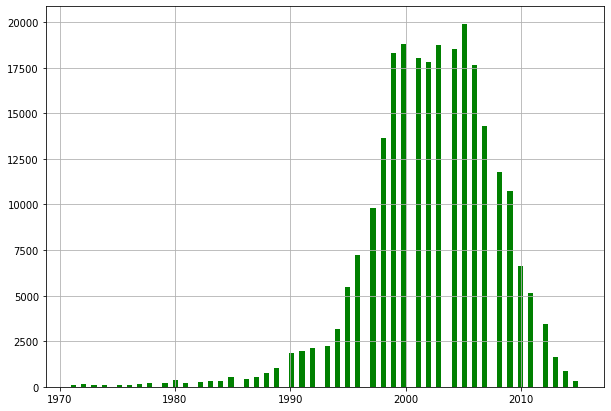

In [20]:
data1 = data1.query('1970 < RegistrationYear < 2016')
data1['RegistrationYear'].hist(bins=100, color='green', figsize=(10,7))
data1['RegistrationYear'].describe()

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Power</b>    
</p>
</div>

count    256164.000000
mean        110.866449
std         182.956599
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64

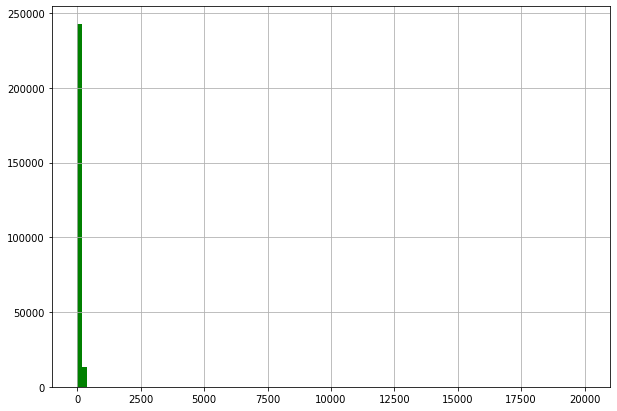

In [21]:
data1['Power'].hist(bins=100, color='green', figsize=(10,7))
data1['Power'].describe()

In [22]:
data1 = data1.query('20 < Power < 250')

count    230844.000000
mean        114.427358
std          42.715708
min          21.000000
25%          75.000000
50%         109.000000
75%         140.000000
max         249.000000
Name: Power, dtype: float64

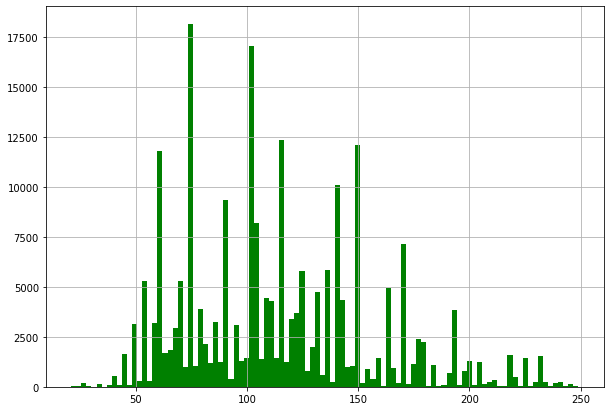

In [23]:
data1['Power'].hist(bins=100, color='green', figsize=(10,7))
data1['Power'].describe()

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Kilometer</b>    
</p>
</div>

count    230844.000000
mean     131228.145414
std       33774.519793
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

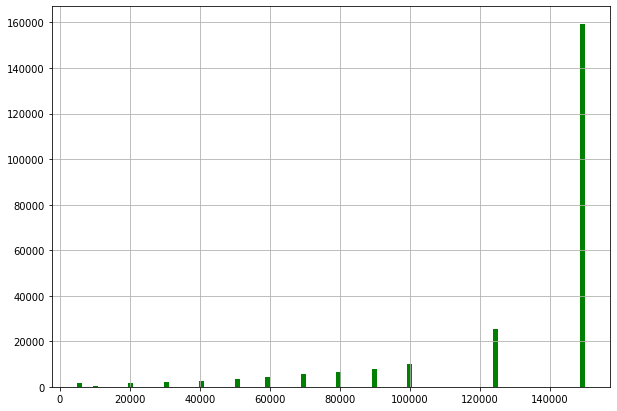

In [24]:
data1['Kilometer'].hist(bins=100, color='green', figsize=(10,7))
data1['Kilometer'].describe()

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Gearbox, NotRepaired, Model</b>    
</p>
</div>

In [25]:
data1.fillna({'Gearbox':'manual', 'NotRepaired':'yes', 'Model':'unknown'},
                          inplace=True)
data1.isna().mean()

VehicleType         0.013100
Repaired            0.133151
FuelType            0.040646
RegistrationYear    0.000000
Gearbox             0.000000
Model               0.000000
Power               0.000000
Kilometer           0.000000
Brand               0.000000
Price               0.000000
dtype: float64

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>VehicleType</b>    
</p>
</div>

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
В столбцах VehicleType и FuelType заполним пропуски значениями типа кузова, наиболее распространненного для конкретной марки марки машины.    
</div>

In [26]:
display(data1['VehicleType'].value_counts())

sedan          66680
small          57717
wagon          48045
bus            22408
convertible    14478
coupe          10118
suv             6425
other           1949
Name: VehicleType, dtype: int64

In [27]:
data1['VehicleType'].isna().sum()

3024

In [28]:
vehicle_type_pivot = data1.pivot_table(index='VehicleType', columns='Brand', values='Price', aggfunc='count')
display(vehicle_type_pivot)

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
VehicleType,,,,,,,,,,,,,,,,,,,,,
bus,NaN,9.0,3.0,103.0,318.0,1073.0,31.0,22.0,27.0,661.0,...,528.0,202.0,NaN,130.0,13.0,23.0,377.0,NaN,7040.0,NaN
convertible,129.0,984.0,2186.0,9.0,181.0,87.0,NaN,1.0,16.0,364.0,...,NaN,2.0,1030.0,168.0,1.0,25.0,59.0,24.0,2189.0,44.0
coupe,188.0,695.0,2466.0,41.0,33.0,115.0,NaN,2.0,NaN,127.0,...,58.0,4.0,287.0,73.0,3.0,1.0,167.0,2.0,901.0,53.0
other,6.0,72.0,163.0,21.0,4.0,76.0,6.0,3.0,3.0,125.0,...,36.0,17.0,4.0,37.0,4.0,8.0,14.0,2.0,524.0,2.0
sedan,708.0,7533.0,12631.0,169.0,175.0,537.0,93.0,71.0,35.0,691.0,...,1330.0,704.0,26.0,182.0,104.0,121.0,769.0,92.0,15069.0,479.0
small,194.0,861.0,294.0,516.0,9.0,1243.0,211.0,170.0,341.0,3766.0,...,2498.0,978.0,2905.0,55.0,72.0,769.0,1393.0,32.0,13382.0,6.0
suv,NaN,11.0,331.0,202.0,8.0,14.0,155.0,1.0,39.0,18.0,...,3.0,46.0,NaN,160.0,46.0,616.0,321.0,NaN,478.0,105.0
wagon,376.0,7647.0,5728.0,88.0,198.0,472.0,223.0,31.0,14.0,288.0,...,260.0,2085.0,8.0,80.0,216.0,67.0,462.0,39.0,9866.0,1471.0


In [29]:
data1[data1['Brand'] == 'alfa_romeo']['VehicleType'].value_counts()

sedan          708
wagon          376
small          194
coupe          188
convertible    129
other            6
Name: VehicleType, dtype: int64

In [30]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230844 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       227820 non-null  object
 1   Repaired          200107 non-null  object
 2   FuelType          221461 non-null  object
 3   RegistrationYear  230844 non-null  int64 
 4   Gearbox           230844 non-null  object
 5   Model             230844 non-null  object
 6   Power             230844 non-null  int64 
 7   Kilometer         230844 non-null  int64 
 8   Brand             230844 non-null  object
 9   Price             230844 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 19.4+ MB


In [31]:
data1.fillna({'VehicleType':0},inplace=True)

In [32]:
def fill_vehicle_type(row, row_number, vehicle_type_pivot):
    brand = row[8]
    fill_value = row[row_number]
    if row[row_number] == 0:
        fill_value = vehicle_type_pivot[brand].idxmax()
    return fill_value

In [33]:
data1['VehicleType'] = data1.apply(fill_vehicle_type, args=[0, vehicle_type_pivot], axis=1)

In [34]:
display(data1['VehicleType'].isna().sum())

0

In [35]:
data1['VehicleType'].value_counts()

sedan          68246
small          58844
wagon          48353
bus            22420
convertible    14478
coupe          10122
suv             6432
other           1949
Name: VehicleType, dtype: int64

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>FuelType</b>    
</p>
</div>

In [36]:
display(data1['FuelType'].value_counts())

petrol      148462
gasoline     68514
lpg           3851
cng            445
hybrid         107
other           62
electric        20
Name: FuelType, dtype: int64

In [37]:
data1['FuelType'].isna().sum()

9383

In [38]:
fuel_type_pivot = data1.pivot_table(index='FuelType', columns='Brand', values='Price', aggfunc='count')
display(fuel_type_pivot)

Brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
FuelType,,,,,,,,,,,,,,,,,,,,,
cng,NaN,NaN,6.0,4.0,NaN,5.0,2.0,NaN,NaN,59.0,...,NaN,6.0,2.0,6.0,2.0,NaN,NaN,NaN,156.0,20.0
electric,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,NaN,NaN,3.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN
gasoline,490.0,7936.0,7337.0,136.0,291.0,1252.0,147.0,1.0,4.0,1117.0,...,1302.0,1388.0,747.0,194.0,21.0,184.0,796.0,1.0,18281.0,729.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,1.0,2.0,NaN,NaN,54.0,NaN,2.0,NaN
lpg,27.0,315.0,556.0,136.0,68.0,55.0,47.0,20.0,3.0,54.0,...,55.0,46.0,3.0,50.0,25.0,12.0,14.0,NaN,421.0,80.0
other,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,1.0,NaN,19.0,9.0,2.0
petrol,1039.0,9048.0,15171.0,846.0,537.0,2235.0,500.0,278.0,459.0,4652.0,...,3259.0,2511.0,3426.0,590.0,395.0,1403.0,2647.0,143.0,29358.0,1271.0


In [39]:
data1.fillna({'FuelType':0},inplace=True)

In [40]:
data1['FuelType'] = data1.apply(fill_vehicle_type, args=[2, vehicle_type_pivot],axis=1)

In [41]:
display(data1['FuelType'].isna().sum())

0

In [42]:
data1['FuelType'].value_counts()

petrol      148462
gasoline     68514
sedan         4435
small         3862
lpg           3851
wagon         1003
cng            445
hybrid         107
other           62
bus             42
suv             37
electric        20
coupe            4
Name: FuelType, dtype: int64

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Дубликаты</b>    
</p>
</div>

In [43]:
data2 = data1.drop_duplicates().reset_index(drop=True)

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Gasoline и petrol  - это разные названия бензина. Сделаем замену replace('gasoline', 'petrol').   
</p>
</div>

In [44]:
data2.FuelType = data2.FuelType.replace('gasoline', 'petrol')

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Пропуски в столбце Repaired заменим на 'no'.   
</p>
</div>

In [45]:
data2.Repaired = data2.Repaired.fillna('no')

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Работа с данными  - оптимизация</b>    
</p>
</div>

In [46]:
data2['Automatic'] = 1
data2.loc[data2['Gearbox'] == 'manual', 'Automatic'] = 0

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Проверка замены типа столбца 'Gearbox'.
</p>
</div>

In [47]:
display(data2['Automatic'].value_counts())
data2['Gearbox'].value_counts()

0    162439
1     35399
Name: Automatic, dtype: int64

manual    162439
auto       35399
Name: Gearbox, dtype: int64

In [48]:
data2['NotRepaired'] = 1
data2.loc[data2['Repaired'] == 'yes', 'NotRepaired'] = 0

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Проверка замены типа столбца 'Repaired'.
</p>
</div>

In [49]:
display(data2['NotRepaired'].value_counts())
data2['Repaired'].value_counts()

1    179889
0     17949
Name: NotRepaired, dtype: int64

no     179889
yes     17949
Name: Repaired, dtype: int64

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Удалим лишние слобцы.
</p>
</div>

In [50]:
data2.drop(['Repaired'], inplace=True, axis=1)

In [51]:
data2.drop(['Gearbox'], inplace=True, axis=1)

In [52]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197838 entries, 0 to 197837
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       197838 non-null  object
 1   FuelType          197838 non-null  object
 2   RegistrationYear  197838 non-null  int64 
 3   Model             197838 non-null  object
 4   Power             197838 non-null  int64 
 5   Kilometer         197838 non-null  int64 
 6   Brand             197838 non-null  object
 7   Price             197838 non-null  int64 
 8   Automatic         197838 non-null  int64 
 9   NotRepaired       197838 non-null  int64 
dtypes: int64(6), object(4)
memory usage: 15.1+ MB


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Загрузили и исследовали данные. Обработали пропуски и дубликаты. Исследовали данные на мультиколлинеарность. 
Произвели преобразование типов данных. 
Выделили значимые признаки. Убрали лишние стобцы в целях оптимизации данных и процесса обучения моделей. 
Обработали выбросы в данных.  
</p>
</div>

## Обучение моделей

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Разделим данные на выборки: обучающую, валидационную и тестовую.</b>
</p>
</div>

In [53]:
target = data2['Price']
features = data2.drop('Price', axis=1)

In [54]:
features_train, features_valid, target_train,target_valid = \
train_test_split(features, target, test_size=0.4, random_state=577)

In [55]:
features_valid, features_test, target_valid, target_test = \
train_test_split(features_valid, target_valid, test_size=0.5, random_state=577)

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Кодирование данных</b>
</p>
</div>

In [56]:
object_cols = ['VehicleType','FuelType','Brand','Model']

In [57]:
features_train1 = features_train.copy()
features_valid1 =features_test.copy()

ordinal_encoder = OrdinalEncoder(handle_unknown='ignore')        

features_train[object_cols] = ordinal_encoder.fit_transform(features_train[object_cols])
features_valid[object_cols] = ordinal_encoder.transform(features_valid[object_cols])
features_test[object_cols] = ordinal_encoder.transform(features_test[object_cols])

In [58]:
features_train.head()

,VehicleType,FuelType,RegistrationYear,Model,Power,Kilometer,Brand,Automatic,NotRepaired
45064,5.0,7.0,2012,75.0,75,50000,27.0,0,1
190985,2.0,7.0,2001,59.0,129,150000,20.0,0,1
59896,0.0,7.0,2010,38.0,140,125000,30.0,1,1
54469,4.0,7.0,1999,115.0,75,150000,38.0,0,0
18314,7.0,7.0,2003,59.0,143,150000,20.0,1,1


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Масштабирование численных признаков</b>
</p>
</div>

In [59]:
num_cols = ['RegistrationYear','Power','Kilometer']
scaler = StandardScaler()
features_train[num_cols] = scaler.fit_transform(features_train[num_cols])
features_valid[num_cols] = scaler.transform(features_valid[num_cols])
features_test[num_cols] = scaler.transform(features_test[num_cols])

In [60]:
features_train.head()

,VehicleType,FuelType,RegistrationYear,Model,Power,Kilometer,Brand,Automatic,NotRepaired
45064,5.0,7.0,1.710105,75.0,-0.940908,-2.312053,27.0,0,1
190985,2.0,7.0,-0.244658,59.0,0.324745,0.573421,20.0,0,1
59896,0.0,7.0,1.354694,38.0,0.582564,-0.147948,30.0,1,1
54469,4.0,7.0,-0.600069,115.0,-0.940908,0.573421,38.0,0,0
18314,7.0,7.0,0.110754,59.0,0.652878,0.573421,20.0,1,1


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>RandomForestRegressor</b>
</p>
</div>

In [61]:
def RMSE(y_true,y_pred):
    error = mean_squared_error(y_true, y_pred) ** 0.5 
    return error

In [62]:
score = make_scorer(RMSE,greater_is_better=False)

In [63]:
model1 = RandomForestRegressor(random_state=577)

In [64]:
param_RF = { 
    'n_estimators': [10,100],
    'max_depth' : [1,15]
    }

In [65]:
%%time
grid_model1 = GridSearchCV(model1,
                           param_grid = param_RF,
                           scoring='neg_mean_squared_error',
                           cv= 5)

CPU times: user 65 µs, sys: 5 µs, total: 70 µs
Wall time: 75.3 µs


In [66]:
%%time
grid_model1.fit(features_train,target_train)

CPU times: user 1min 59s, sys: 407 ms, total: 1min 59s
Wall time: 1min 59s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=577),
             param_grid={'max_depth': [1, 15], 'n_estimators': [10, 100]},
             scoring='neg_mean_squared_error')

In [67]:
print("Лучшая модель-1")
print(grid_model1.best_estimator_)

Лучшая модель-1
RandomForestRegressor(max_depth=15, random_state=577)


In [68]:
best_score_model1 = grid_model1.best_score_

In [69]:
print("RandomForestRegressor",best_score_model1)

RandomForestRegressor -1494032.8933526084


In [70]:
%%time
predicted_valid = grid_model1.predict(features_valid)

CPU times: user 736 ms, sys: 0 ns, total: 736 ms
Wall time: 778 ms


In [71]:
print('-RandomForestRegressor-')
rmse_val = RMSE(target_valid,predicted_valid)
print('-RMSE на валидационной выборке-',rmse_val)

-RandomForestRegressor-
-RMSE на валидационной выборке- 1196.396951834727


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>LGBMRegressor</b>
</p>
</div>

In [72]:
%%time
model2 = lgb.LGBMRegressor(objective ='regression',random_state = 577)

params_lgbm = {
    'num_leaves':[10,30],
    'learning_rate':[0.07,],     
    'n_estimators':[100,1000],
    'colsample_bytree': [0.5,],
    'subsample': [0.6633,],
    'reg_alpha': [0.05,], 
    'reg_lambda': [0],
               } 
   
grid_model2 = GridSearchCV(estimator=model2, 
                                param_grid=params_lgbm,
                                verbose = 1, 
                                cv = 5,
                                scoring='neg_mean_squared_error', 
                                n_jobs=-1).fit(features_train,target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 3h 11min 14s, sys: 1min 51s, total: 3h 13min 6s
Wall time: 3h 14min 9s


In [73]:
%%time
grid_model2.fit(features_train,target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 8min 57s, sys: 2.11 s, total: 8min 59s
Wall time: 9min 3s


GridSearchCV(cv=5,
             estimator=LGBMRegressor(objective='regression', random_state=577),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5], 'learning_rate': [0.07],
                         'n_estimators': [100, 1000], 'num_leaves': [10, 30],
                         'reg_alpha': [0.05], 'reg_lambda': [0],
                         'subsample': [0.6633]},
             scoring='neg_mean_squared_error', verbose=1)

In [74]:
print("Лучшая модель-2")
print(grid_model2.best_estimator_)

Лучшая модель-2
LGBMRegressor(colsample_bytree=0.5, learning_rate=0.07, n_estimators=1000,
              num_leaves=30, objective='regression', random_state=577,
              reg_alpha=0.05, reg_lambda=0, subsample=0.6633)


In [75]:
best_score_model2 = grid_model2.best_score_

In [76]:
print("LGBMRegressor",best_score_model2)

LGBMRegressor -1360649.7327523432


In [77]:
%%time
predicted_valid = grid_model2.predict(features_valid)

CPU times: user 4.11 s, sys: 477 µs, total: 4.11 s
Wall time: 4.07 s


In [78]:
print('-LGBMRegressor-')
rmse_val = RMSE(target_valid,predicted_valid)
print('-RMSE на валидационной выборке-',rmse_val)

-LGBMRegressor-
-RMSE на валидационной выборке- 1150.3600267105646


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>XGBRegressor</b>
</p>
</div>

In [79]:
model3 = XGBRegressor(random_state=577) 

In [80]:
param_set = {"learning_rate": [0.07,], 
                        "max_depth": [ 3, 4, 5, 8],
                        "min_child_weight": [2],
                        "gamma":[ 0.0, 0.1, 0.2],
                        "colsample_bytree":[0.3],}

In [81]:
%%time
grid_model3 = GridSearchCV(estimator=model3,
                           param_grid=param_set,
                           cv=3, 
                           scoring='neg_mean_squared_error', 
                           verbose=0, 
                           n_jobs=-1)

CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 45.5 µs


In [82]:
%%time
grid_model3.fit(features_train,target_train)

CPU times: user 10min 47s, sys: 2.55 s, total: 10min 50s
Wall time: 10min 56s


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    num_parallel_tree=None, predictor=None,
                                    random_state=577, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                  

In [83]:
print("Лучшая модель-3")
print(grid_model3.best_estimator_)

Лучшая модель-3
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.07, max_delta_step=0,
             max_depth=8, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=577,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [84]:
best_score_model3 = grid_model3.best_score_

In [85]:
print("XGBRegressor",best_score_model3)

XGBRegressor -1795469.7613756184


In [86]:
%%time
predicted_valid = grid_model3.predict(features_valid)

CPU times: user 173 ms, sys: 0 ns, total: 173 ms
Wall time: 111 ms


In [87]:
print('-XGBRegressor-')
rmse_val = RMSE(target_valid,predicted_valid)
print('-RMSE на валидационной выборке-',rmse_val)

-XGBRegressor-
-RMSE на валидационной выборке- 1326.316392796363


## Анализ моделей

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Обучили и исследовали три модели: RandomForestRegressor, LGBMRegressor, XGBRegressor. Для оценки качества моделей обучили константную модель DummyRegressor. Получили следующие результаты:
</p>
</div>

In [95]:
print('-RandomForestRegressor-')
print('-RMSE на валидационной выборке- 1196.39')
print('-Время обучения модели- 9min 3s') 
print('-Скорость предсказания- 778 ms') 
print('')
print('-LGBMRegressor-')
print('-RMSE на валидационной выборке- 1150.36')
print('-Время обучения модели- 9min 3s') 
print('-Скорость предсказания- 5.22s')
print('')
print('-XGBRegressor-')
print('-RMSE на валидационной выборке- 1326.31')
print('-Время обучения модели- 10min 56s') 
print('-Скорость предсказания- 111ms')

-RandomForestRegressor-
-RMSE на валидационной выборке- 1196.39
-Время обучения модели- 9min 3s
-Скорость предсказания- 778 ms

-LGBMRegressor-
-RMSE на валидационной выборке- 1150.36
-Время обучения модели- 9min 3s
-Скорость предсказания- 5.22s

-XGBRegressor-
-RMSE на валидационной выборке- 1326.31
-Время обучения модели- 10min 56s
-Скорость предсказания- 111ms


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Самые лучшие результаты по качеству предсказания и по времени обучения показала модель: LGBMRegressor с результатами: -RMSE на валидационной выборке- 1148.52, -Время обучения модели- 4min 40s, -Скорость предсказания- 5.22s.
</p>
</div>

In [89]:
%%time
predicted_test = grid_model2.predict(features_test)

CPU times: user 4.09 s, sys: 0 ns, total: 4.09 s
Wall time: 4.09 s


In [90]:
print('-LGBMRegressor-')
rmse_val = RMSE(target_test,predicted_test)
print('-RMSE на тестовой выборке-',rmse_val)

-LGBMRegressor-
-RMSE на тестовой выборке- 1162.3085872567285


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Результаты предсказания лучшей модели LGBMRegressor на тестовой выборке: -RMSE на тестовой выборке- 1162.30,  -Скорость предсказания- 4.09s. Цель проекта достигнула, получено RMSE, меньше 2500.
</p>
</div>

<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
<b>Обучим константную модель и оценим адекватность нашей модели</b>
</p>
</div>

In [91]:
model4 = DummyRegressor(strategy="median")

In [92]:
model4.fit(features_train,target_train)

DummyRegressor(strategy='median')

In [93]:
predicted_test = model4.predict(features_test)

In [94]:
print('-Оценка Константной модели-')
rmse_val = RMSE(target_test,predicted_test)
print('-RMSE на тестовой выборке-',rmse_val)

-Оценка Константной модели-
-RMSE на тестовой выборке- 3007.2082790551895


<div style="background-color: WhiteSmoke; border-left: 7px solid Silver">
<p>
Обучили констрантную модель DummyRegressor. Результат: -Оценка Константной модели-
-RMSE на тестовой выборке- 3007.20. Это значение является намного худшим результатом, чем результат полученной лучшей модели LGBMRegressor на тестовой выборке 1162.37. 
</p>
</div>